# ***Introduction***

### ***Playground Series - Season 3, Episode 2 competition.***

This was an attempt to get a good score without using any documentation, discussion forums or any other external sources on this competition, 
all the code and ideas are original.

Read more about the competition here: [Playground Series - Season 3, Episode 2](https://www.kaggle.com/competitions/playground-series-s3e2/overview)

By David Vikstrand

<img src="https://gcdnb.pbrd.co/images/R2hXGkg0a0YL.png?o=1">

In [1]:
%%capture
!pip install jupyter_black
!pip install plotly
!pip install imblearn
!pip install lightgbm
# !pip install catboost
# !pip install optuna
!pip install kaggle

In [5]:
!kaggle competitions download -c playground-series-s3e2
!unzip playground-series-s3e2.zip

  0%|                                                | 0.00/321k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 321k/321k [00:00<00:00, 11.2MB/s]


In [25]:
import os

os.environ["KAGGLE_USERNAME"] = "davidvikstrand"
os.environ["KAGGLE_KEY"] = XX

import jupyter_black

jupyter_black.load()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

import itertools
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

from colorama import Fore, Back, Style

import xgboost as xgb
import lightgbm as lgb

# import catboost as cb

import gc

# import optuna

import warnings


bold = ["\033[1m", "\033[0m"]
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

# ***Data Exploration***

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Stroke Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original.

As you can see below, I will also utilize the original dataset. Follow for a comparison of the two datasets.

In [55]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ss = pd.read_csv("sample_submission.csv")
org = pd.read_csv("healthcare-dataset-stroke-data.csv")


print("Training shape:", train.shape)
print("Testing shape:", test.shape)
train.pop("id")
test.pop("id")
org.pop("id")

train.head()

Training shape: (15304, 12)
Testing shape: (10204, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [27]:
pd.DataFrame(
    {
        "train_na": train.isna().sum(),
        "test_na": test.isna().sum(),
        "nunique": train.nunique(),
        "dtypes": train.dtypes,
    }
)

,train_na,test_na,nunique,dtypes
Residence_type,0,0.0,2,object
age,0,0.0,106,float64
avg_glucose_level,0,0.0,3740,float64
bmi,0,0.0,407,float64
ever_married,0,0.0,2,object
gender,0,0.0,3,object
heart_disease,0,0.0,2,int64
hypertension,0,0.0,2,int64
smoking_status,0,0.0,4,object
stroke,0,NaN,2,int64


***Notes:*** 

No null values in the dataset

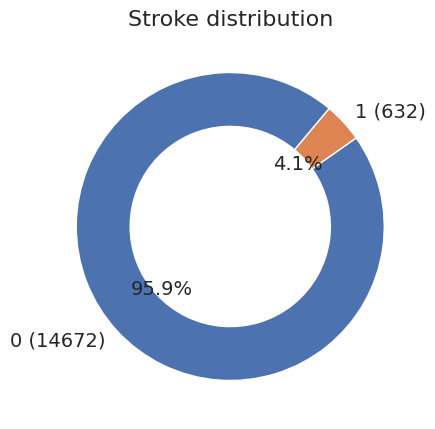

In [61]:
c = train.stroke.value_counts()
labels_sizes = [f"{label} ({size})" for label, size in c.items()]

pie_props = {"width": 0.35, "edgecolor": "white"}
pie_kw = {
    "autopct": "%1.1f%%",
    "textprops": {"fontsize": 14},
    "startangle": 50,
    "wedgeprops": pie_props,
}

fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(c.values, labels=labels_sizes, **pie_kw)

ax.set_title("Stroke distribution", fontsize=16)
plt.show()

***Notes:***

The dataset is imbalanced, with 0.4% of the data being positive for stroke. We have to find a way to deal with this.

In [28]:
df = train.copy()

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,15304.0,41.417708,21.444673,0.08,26.0,43.00,57.00,82.0
hypertension,15304.0,0.049726,0.217384,0.00,0.0,0.00,0.00,1.0
heart_disease,15304.0,0.023327,0.150946,0.00,0.0,0.00,0.00,1.0
avg_glucose_level,15304.0,89.039853,25.476102,55.22,74.9,85.12,96.98,267.6
bmi,15304.0,28.112721,6.722315,10.30,23.5,27.60,32.00,80.1
stroke,15304.0,0.041296,0.198981,0.00,0.0,0.00,0.00,1.0


### ***Correlation***

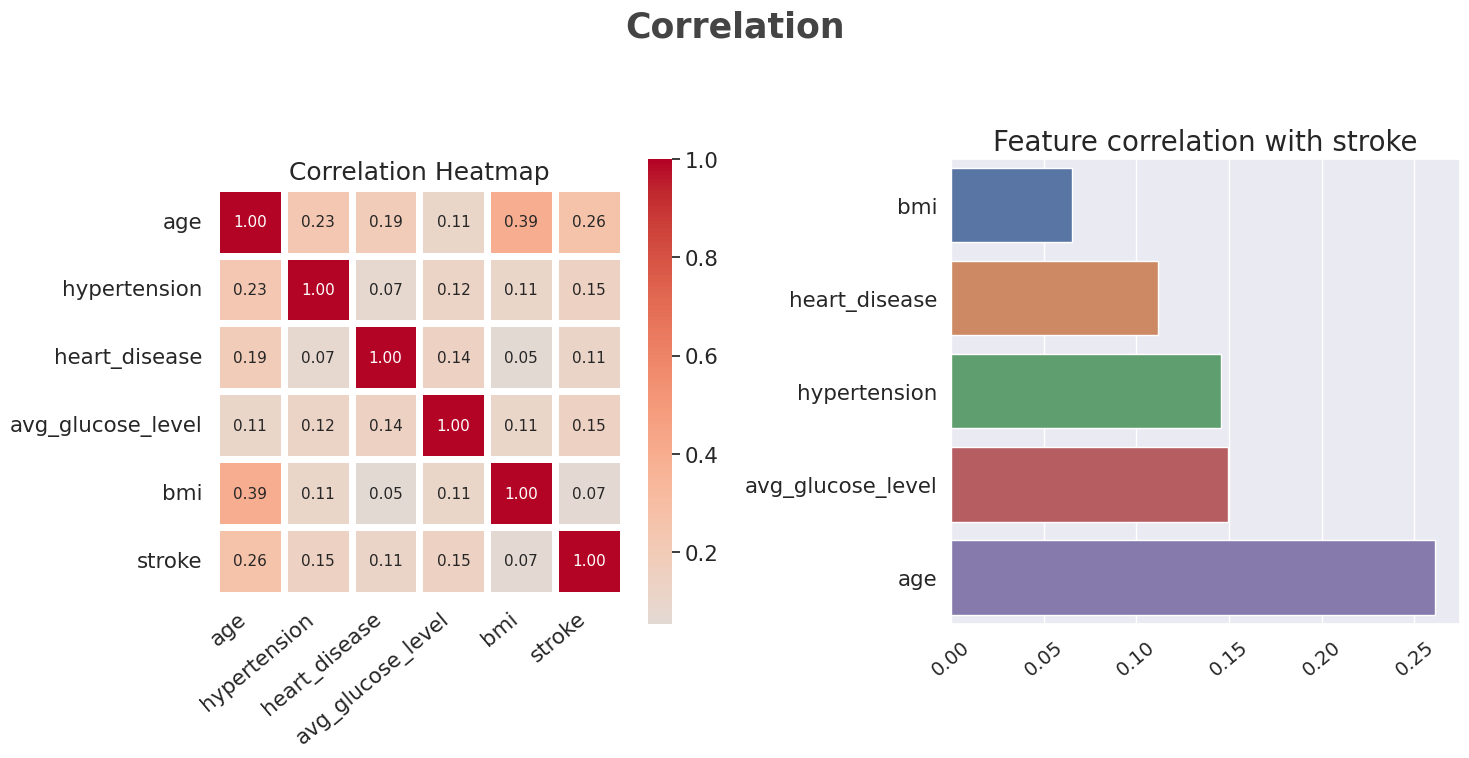

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7))

fig.suptitle(
    "Correlation",
    size=25,
    fontweight="bold",
    y=1.05,
    color="#444444",
)
heatmap = sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 11},
    linewidths=5,
    linecolor="white",
    square=True,
    center=0,
    ax=ax1,
)
heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=40, horizontalalignment="right"
)
heatmap.set_title("Correlation Heatmap", fontsize=18)


corr_values = df.drop(["stroke"], axis=1).corrwith(df["stroke"]).sort_values()
sns.barplot(
    x=corr_values.values,
    y=corr_values.index,
    orient="h",
    ax=ax2,
)
ax2.set_title("Feature correlation with stroke", fontsize=20)
ax2.tick_params(axis="x", labelrotation=40, labelsize=14)

plt.tight_layout()
plt.show()

***Notes***

Correlation is low in general

### ***Continuous columns***

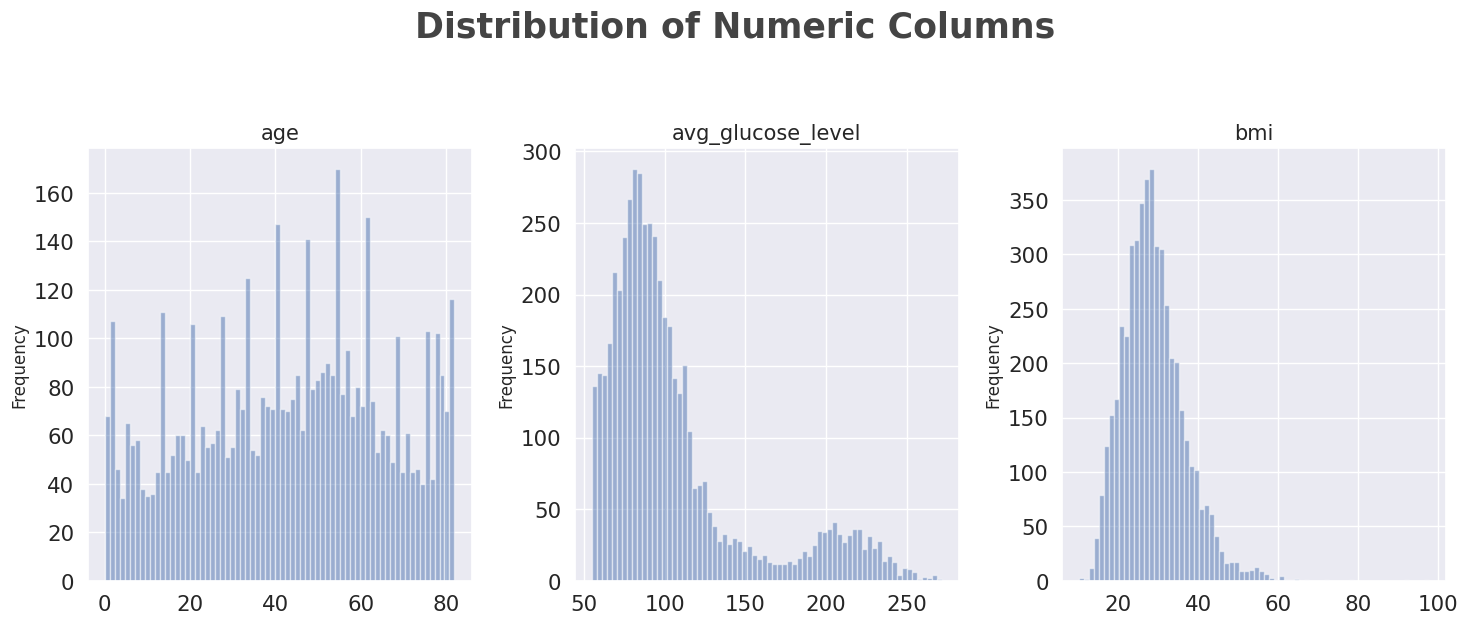

In [11]:
numeric_cols = df.select_dtypes(include=float).columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].plot.hist(bins=70, alpha=0.5, ax=axes[i])
    axes[i].set_title(col, fontsize=15)
    axes[i].set_ylabel("Frequency", fontsize=12)
fig.suptitle(
    "Distribution of Numeric Columns",
    size=25,
    fontname="DejaVu Sans",
    fontweight="bold",
    y=1.05,
    color="#444444",
)
fig.tight_layout()
plt.show();

In [200]:
fig = px.scatter_3d(
    df,
    x="age",
    y="avg_glucose_level",
    z="bmi",
    color="stroke",
    opacity=0.7,
    width=800,
    height=600,
)
fig.show()

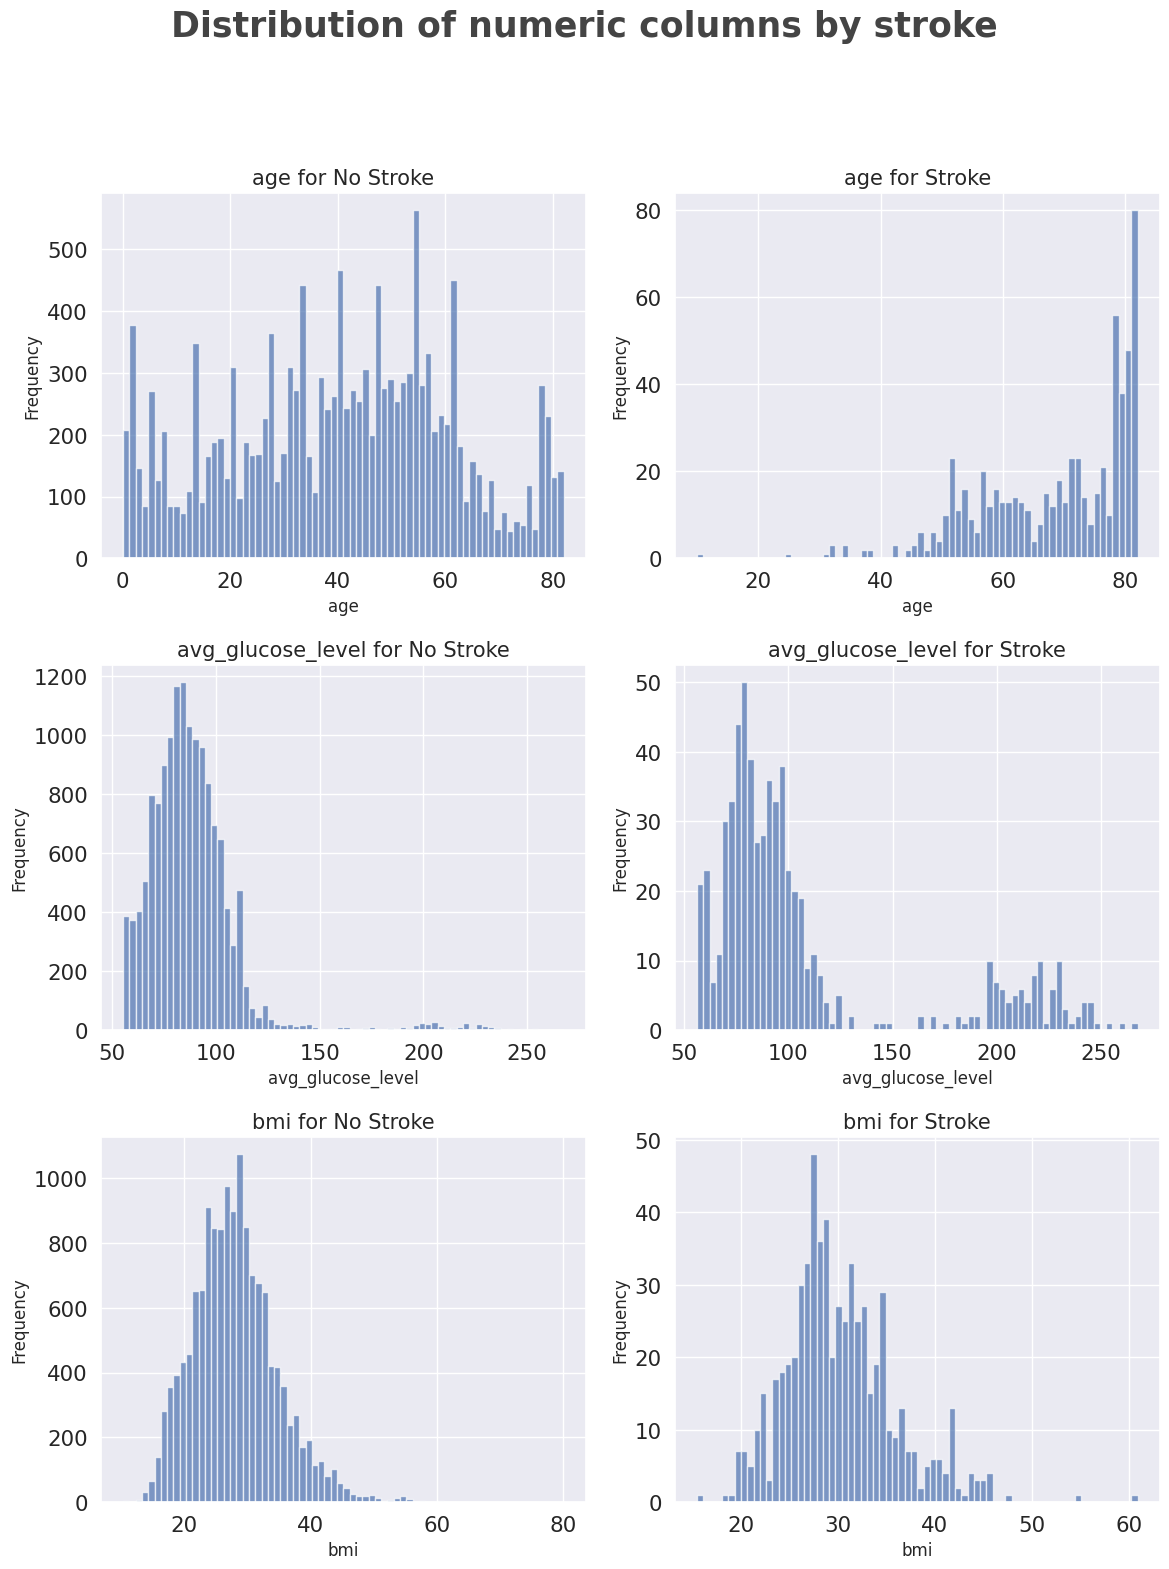

In [33]:
numeric_cols = df.select_dtypes(include=float).columns

fig, axes = plt.subplots(
    nrows=len(numeric_cols), ncols=2, figsize=(12, 5 * len(numeric_cols))
)

for i, col in enumerate(numeric_cols):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    df[df["stroke"] == 0][col].plot.hist(bins=70, alpha=0.7, ax=ax1)
    df[df["stroke"] == 1][col].plot.hist(bins=70, alpha=0.7, ax=ax2)
    ax1.set_title(f"{col} for No Stroke", fontsize=15)
    ax2.set_title(f"{col} for Stroke", fontsize=15)
    ax1.set_xlabel(col, fontsize=12)
    ax2.set_xlabel(col, fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
fig.suptitle(
    "Distribution of numeric columns by stroke",
    size=25,
    fontname="DejaVu Sans",
    fontweight="bold",
    y=1.05,
    color="#444444",
)
fig.tight_layout()
plt.show();

***Notes***


**Age**: For people with stroke, i can see three different groups, 0-40 have a very low chance of having a stroke, 40-80 have a higher chance of having a stroke, and 80+ have a high chance of having a stroke.
This can be added as a new feature.

**Avg_glucose_level**: Levels above 200 seems to be correlated with stroke.

### ***Categorical Columns***

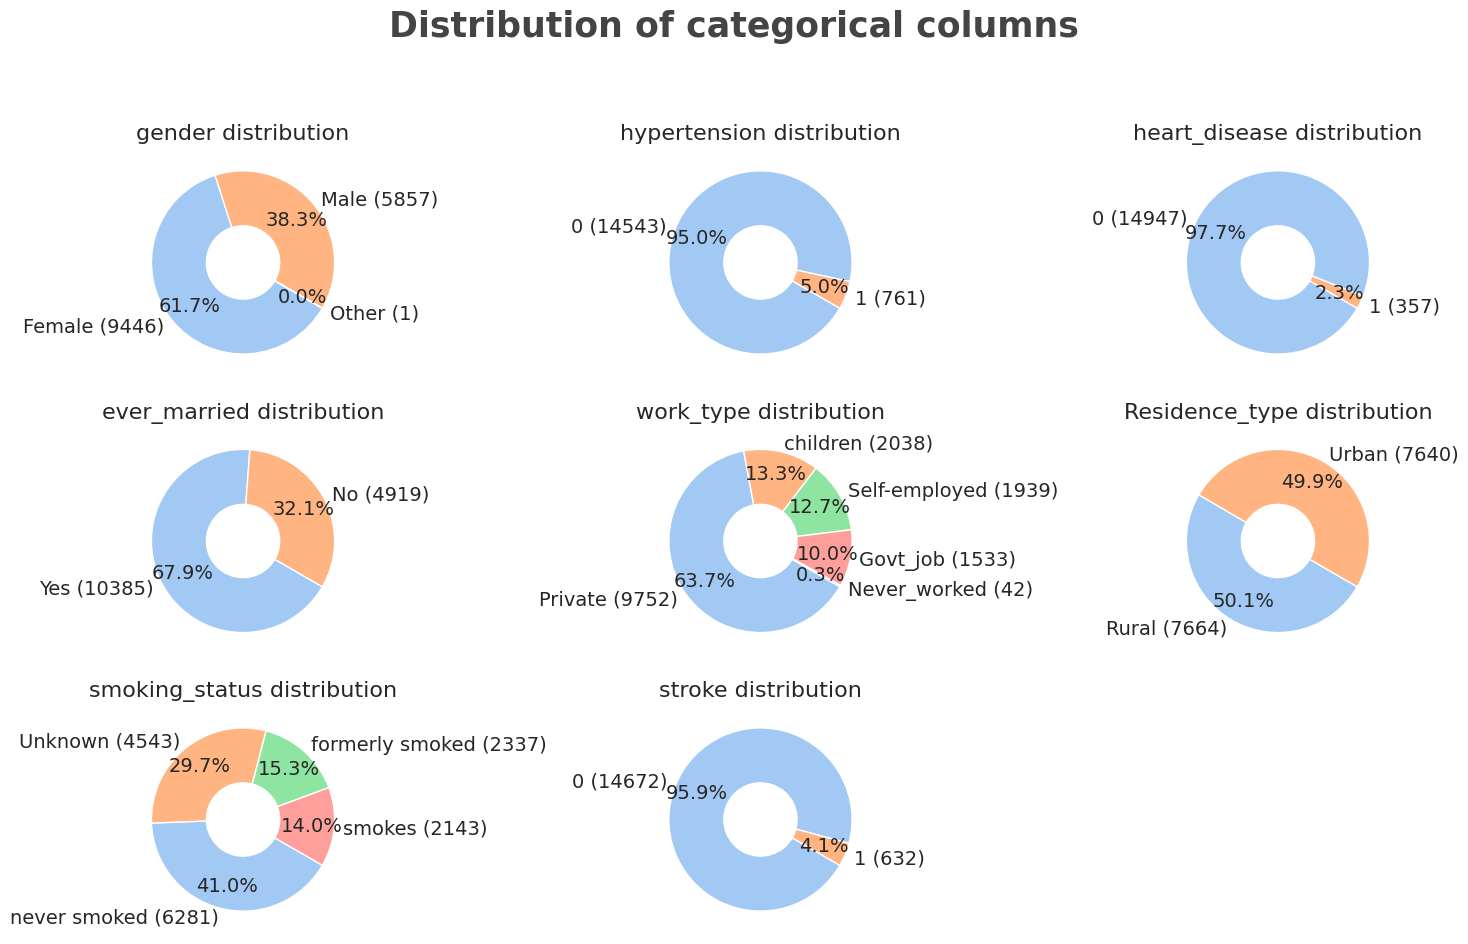

In [35]:
category_cols = df.columns[df.nunique() < 100]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()


for i, col in enumerate(category_cols):
    c = df[col].value_counts()

    labels_sizes = [f"{label} ({size})" for label, size in c.items()]

    axes[i].pie(
        c.values,
        labels=labels_sizes,
        autopct="%1.1f%%",
        textprops={"fontsize": 14},
        wedgeprops=dict(width=0.6),
        startangle=-30,
        counterclock=False,
        colors=sns.color_palette("pastel"),
        pctdistance=0.75,
    )

    axes[i].set_title(f"{col} distribution", fontsize=16)

axes[5].axis("off")
fig.suptitle(
    "Distribution of categorical columns",
    size=25,
    fontname="DejaVu Sans",
    fontweight="bold",
    color="#444444",
)

axes[8].axis("off")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

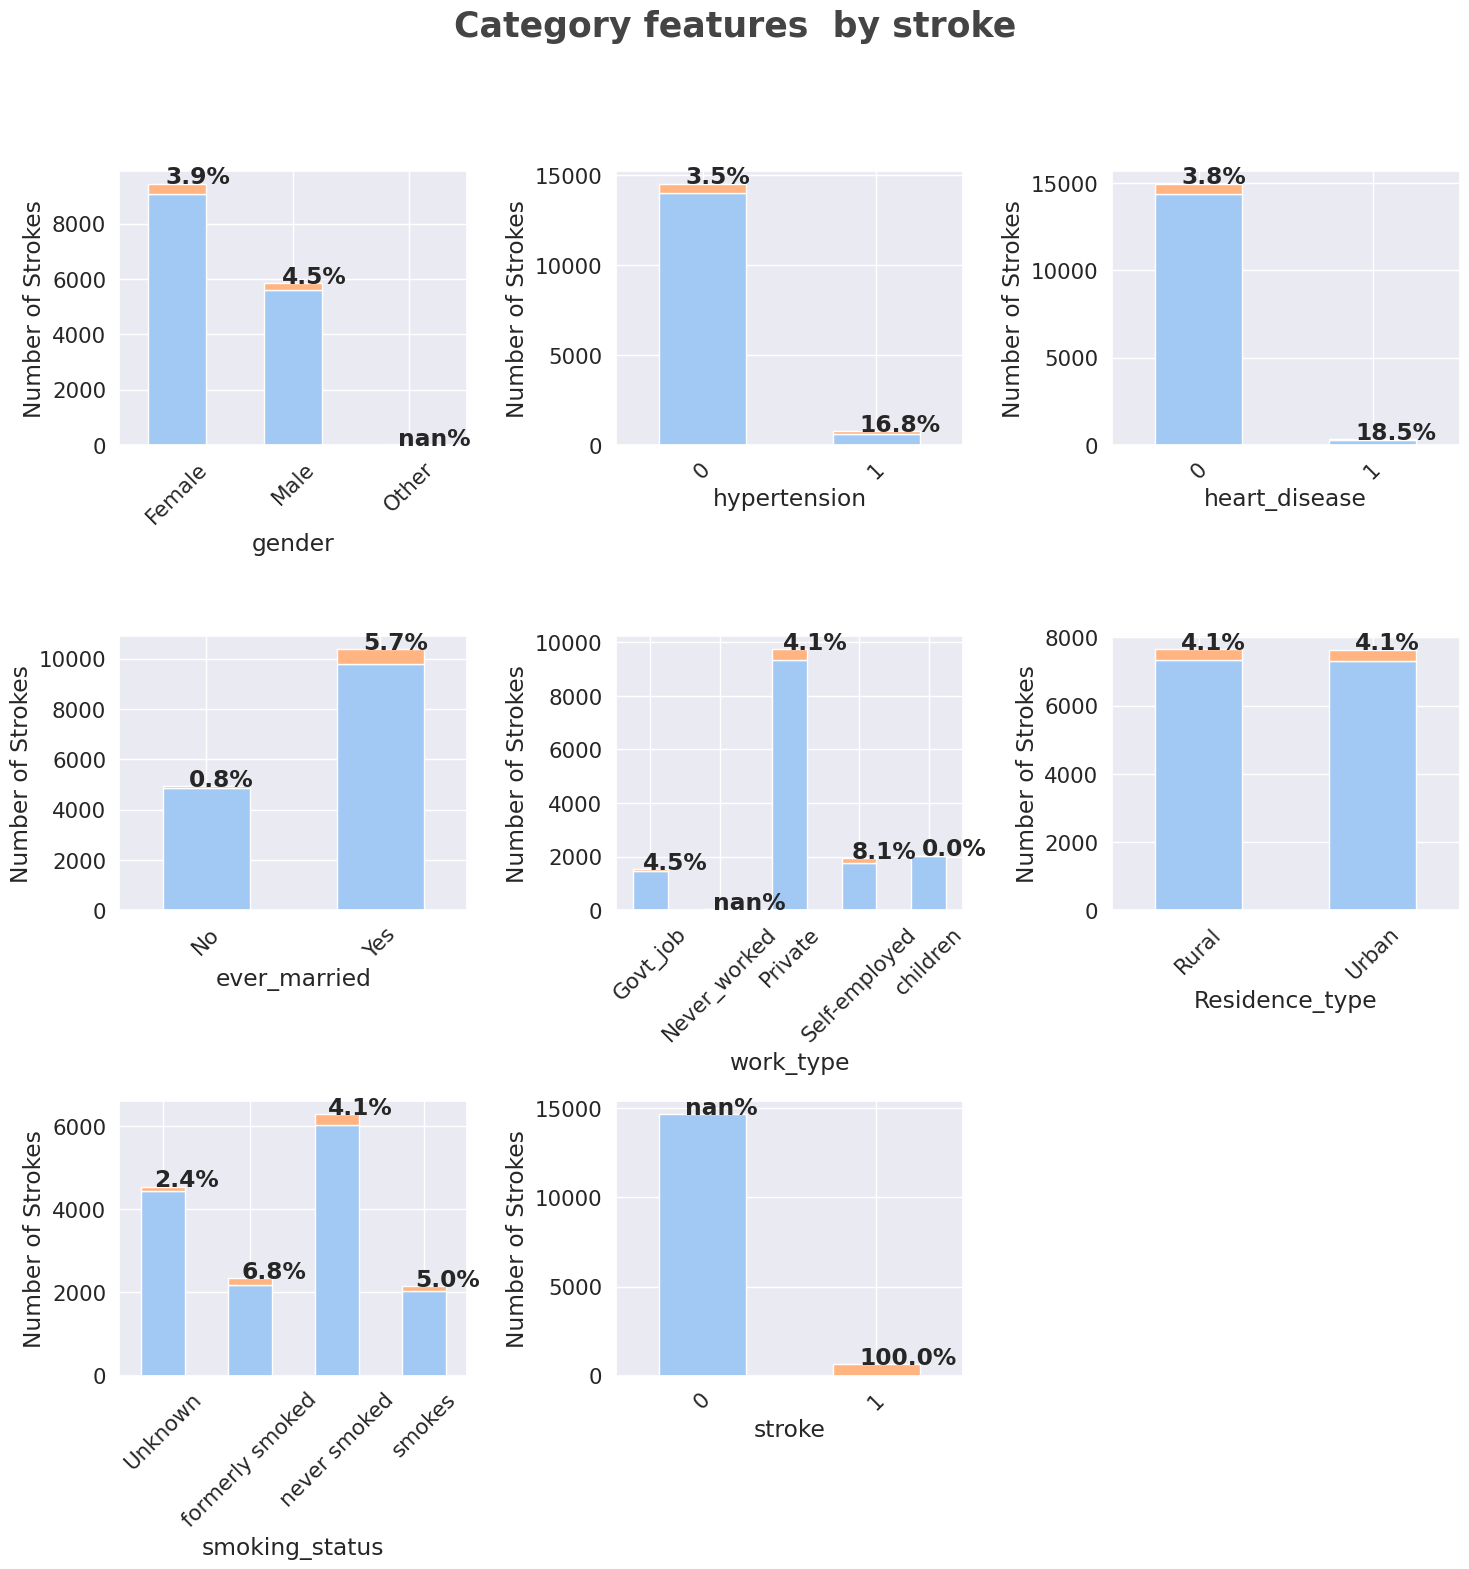

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

colors = sns.color_palette("pastel")

for i, col in enumerate(category_cols):
    gender_stroke = df.groupby([col, "stroke"])["stroke"].count().unstack()
    gender_stroke.plot(kind="bar", stacked=True, ax=axes[i], color=colors)

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Number of Strokes")

    total = gender_stroke.sum(axis=1)
    percent = (gender_stroke[1] / total) * 100

    for j, v in enumerate(percent):
        axes[i].text(j - 0.1, total[j] + 2, f"{v:.1f}%", fontweight="bold")

    axes[i].get_legend().remove()
    axes[i].tick_params(axis="x", rotation=45)

fig.suptitle(
    "Category features  by stroke",
    size=25,
    fontname="DejaVu Sans",
    fontweight="bold",
    y=1.05,
    color="#444444",
)

axes[8].axis("off")
plt.tight_layout()
plt.show()

# ***Data Comparison***

I will now explore the original data vs the generated and compare the distributions of the features.

In [ ]:
ntiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

frames = []
for fr, t in zip((train, test, org), ("train", "test", "original")):
    a = fr.drop(["stroke"], axis=1, errors="ignore").describe(percentiles=ntiles).T
    a.insert(0, "source", t)
    a = a.drop(["count"], axis=1).reset_index().set_index(["index", "source"])

    frames.append(a)

dif = pd.concat([*frames], axis=0).sort_index(ascending=[True, False])

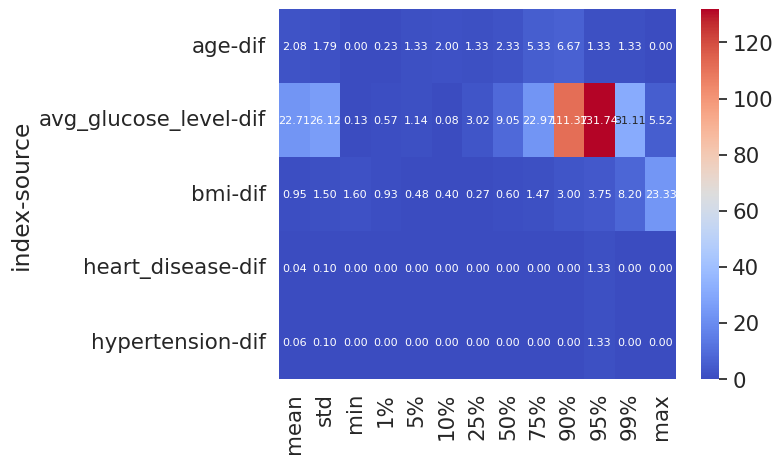

In [ ]:
for col in dif.index.get_level_values(0).unique():
    d = dif.loc[col].sum()

    for c in d.keys():
        d[c] = abs((dif.loc[col][c] - dif.loc[col][c].mean())).sum()

    dd = pd.DataFrame(d).T
    dd = dd.assign(source="dif", type=col).set_index(["type", "source"])
    dif = pd.concat([dif, dd]).sort_index(ascending=[True, False])

sns.heatmap(
    dif.loc[(slice(None), "dif"), :].round(2),
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    cmap="coolwarm",
);

We can see that the distributions are very similar, except for "avg_glucose_level". Let's visualize the distribution of this feature.

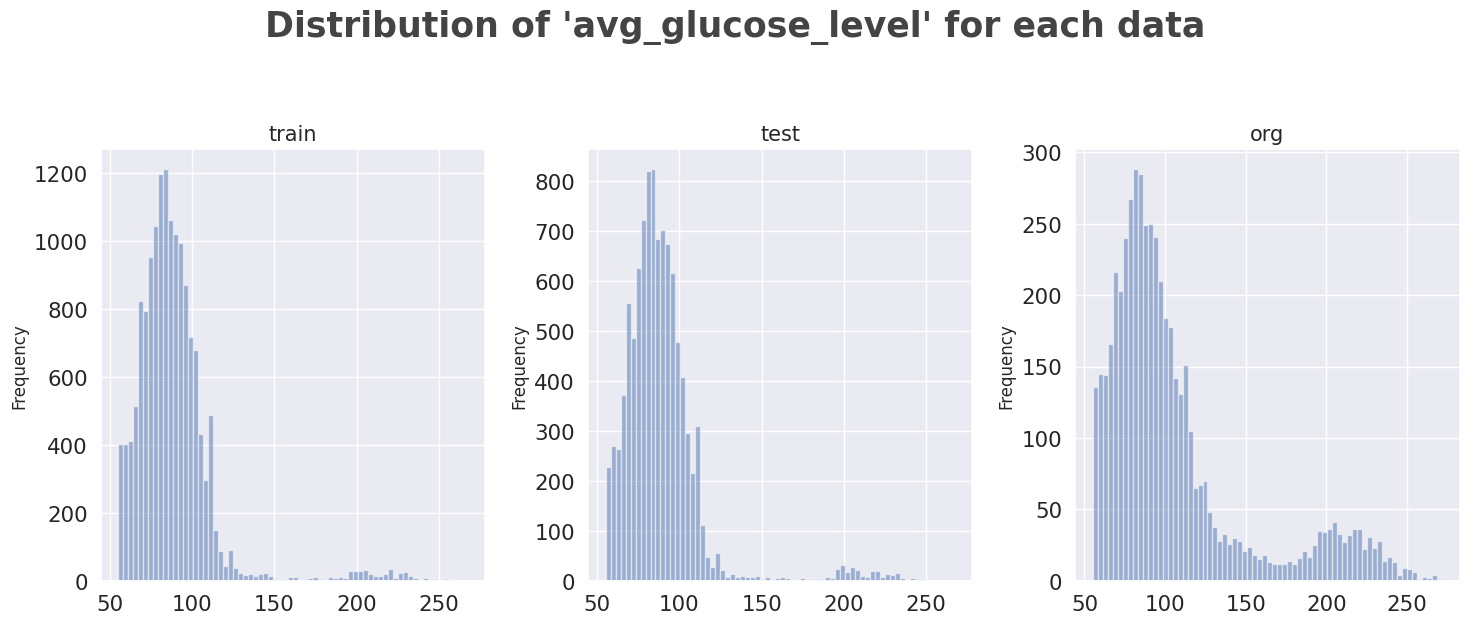

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
axes = axes.flatten()

for i, (df, name) in enumerate(zip((train, test, org), ("train", "test", "org"))):
    p = df["avg_glucose_level"]
    p.plot.hist(bins=70, alpha=0.5, ax=axes[i])
    axes[i].set_title(name, fontsize=15)
    axes[i].set_ylabel("Frequency", fontsize=12)
fig.suptitle(
    "Distribution of 'avg_glucose_level' for each data",
    size=25,
    fontname="DejaVu Sans",
    fontweight="bold",
    y=1.05,
    color="#444444",
)
fig.tight_layout()
plt.show();

Train and test dataset shows similar distributions. Original have higher values above 150.

In [ ]:
train["stroke"].value_counts(normalize=True), org["stroke"].value_counts(normalize=True)

(0    0.958704
 1    0.041296
 Name: stroke, dtype: float64,
 0    0.951272
 1    0.048728
 Name: stroke, dtype: float64)

We can also notice that the original dataset has a higher percentage of positive values for stroke. Maybe there is a correlation between high glucose levels and stroke?

<AxesSubplot: ylabel='Frequency'>

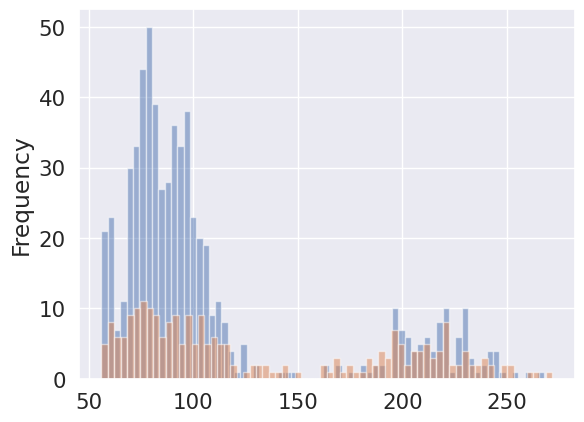

In [ ]:
train[train["stroke"] == 1]["avg_glucose_level"].plot.hist(bins=70, alpha=0.5)
org[org["stroke"] == 1]["avg_glucose_level"].plot.hist(bins=70, alpha=0.5);

If we compare the glucose level distributions for only positive stroke cases, we can see that the original data has a lower stroke percentage for lower glucose levels compared to the train data.

# ***EDA***

### ***Bmi***

In [15]:
org.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Original data has some nan values, so we have to deal with that. Since we saw that "age" and "avg_glucose_level" had the highest correlation with stroke, we will use these features to fill the nan values.

First we will group each feature into subgroups, and then we will fill the nan values based on these subgroups.

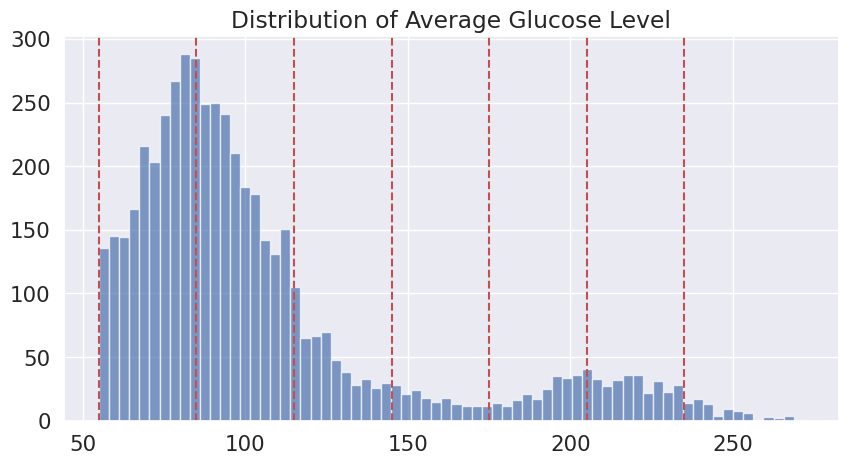

In [16]:
plt.figure(figsize=(10, 5))
org["avg_glucose_level"].hist(bins=70, alpha=0.7)
plt.title("Distribution of Average Glucose Level")

for x in range(55, 250, 30):
    plt.axvline(x=x, color="r", linestyle="--")

plt.show()

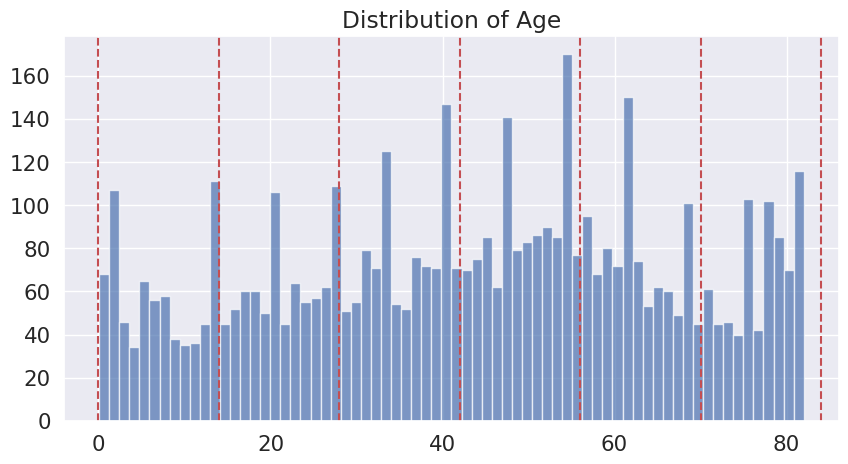

In [17]:
plt.figure(figsize=(10, 5))
org["age"].hist(bins=70, alpha=0.7)
plt.title("Distribution of Age")

for x in range(0, 85, 14):
    plt.axvline(x=x, color="r", linestyle="--")

plt.show()

This looks looks like a good way to group "avg_glucose_level" and "age".

In [62]:
c_clu = list(range(55, 221, 33)) + [np.inf]
c_age = list(range(0, 85, 14)) + [np.inf]
org_cols = "avg_glucose_level", "age"

for cut, org_c, new_c in zip([c_clu, c_age], org_cols, ["glucose_cut", "age_cut"]):
    org[new_c] = pd.cut(org[org_c], cut, labels=(range(len(cut) - 1)))

In [19]:
org.groupby(["glucose_cut", "age_cut"])["bmi"].size().unstack().fillna(0)

age_cut,0,1,2,3,4,5,6
glucose_cut,,,,,,,
0,332,367,451,471,360,264,0
1,269,290,333,398,276,203,0
2,72,78,65,81,57,40,0
3,16,16,28,41,27,29,0
4,9,11,32,70,112,107,0
5,1,3,15,42,77,67,0


Here are the number of rows for each subgroup. We will now use the mean of each subgroup to fill the nan values for "bmi"

In [64]:
org["bmi"] = org.groupby(["glucose_cut", "age_cut"])["bmi"].transform(
    lambda x: x.fillna(x.mean())
)

Now let's drop the new features we created and combine the train and original data

In [65]:
org = org.drop(columns=["glucose_cut", "age_cut"], axis=1)
df = pd.concat([train, org[org["stroke"] == 1]], axis=0).reset_index(drop=True)

### ***Age***

Some of the values in "age" are floats and seems to not represent real ages. I will drop these for now

In [21]:
df[df["age"] % 1 != 0]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
21,Female,1.72,0,0,No,children,Rural,94.12,20.800000,Unknown,0
104,Female,0.32,0,0,No,children,Rural,111.65,16.200000,Unknown,0
176,Male,1.32,0,0,No,children,Rural,56.11,22.900000,Unknown,0
205,Female,1.32,0,0,No,children,Urban,110.63,22.800000,Unknown,0
259,Male,1.80,0,0,No,children,Rural,60.98,17.200000,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
15262,Male,0.40,0,0,No,children,Urban,77.87,18.400000,Unknown,0
15269,Male,1.88,0,0,No,children,Urban,104.55,18.900000,Unknown,0
15270,Female,0.72,0,0,No,children,Rural,108.18,19.100000,Unknown,0
15292,Female,0.32,0,0,No,children,Urban,89.04,17.800000,Unknown,0


In [66]:
df = df[df["age"] % 1 == 0]

# ***Preprocessing***

The biggest challenge in this competition is the imbalanced dataset. We will have to deal with this in some way. I have experimented with different methods from the imblearn library, testing both SMOTEENN (under and oversampling combined) and  NeighbourhoodCleaningRule (undersampling) to see wich gave the best results. But before we can do that, we have to transform all the categorical features into numerical features. I will use LabelEncoder for this. 

I will also set the gender "Other" to 0, since its only 1 in each data.

In [67]:
len(df[df.gender == "Other"]), len(test[test.gender == "Other"])

(1, 1)

In [68]:
seed = 420
obj_cols = df.select_dtypes(include=object).columns

for fr in df, test:
    for col in fr.select_dtypes("object").columns:
        fr[col] = LabelEncoder().fit_transform(fr[col].astype(str))

    fr.loc[fr["gender"] == 2, "gender"] = 0

### ***SMOTEENN***

SMOTEENN is a popular method for dealing with imbalanced datasets. It combines over and undersampling to get the best of both worlds. It will oversample the minority class, and then undersample the majority class. This will give us a dataset with a near 50/50 split. 

But, when I applied this method to the data, the models started to overfit the synthetic data and gave poor results. My conclusion to this is that there is maybe more effective to only undersample the data by removing some of the majority class. I will use NeighbourhoodCleaningRule for this.

In [25]:
X = df.copy()
y = X.pop("stroke")

X, y = SMOTEENN().fit_resample(X, y)
y.value_counts(normalize=True)

1    0.550002
0    0.449998
Name: stroke, dtype: float64

### ***NCR***

Neighborhood Cleaning Rule (NCR) is a data cleaning technique used in imbalanced datasets to remove noisy samples from the majority class. It works by identifying samples in the majority class that are close to the minority class and removing them.

The NCR algorithm consists of the following steps:

1. Identify the k-nearest neighbors of each sample in the minority class.
2. Calculate the average distance between each sample in the minority class and its k-nearest neighbors.
3. For each sample in the majority class, identify its k-nearest neighbors.
4. If the average distance between the sample and its k-nearest neighbors is smaller than the average distance between the sample and its k-nearest neighbors in the minority class, remove the sample from the dataset.

In other words, NCR removes samples from the majority class that are located in areas of the feature space that are close to the minority class. This helps to reduce the noise in the majority class and improve the performance of classifiers trained on imbalanced datasets.


Let's try out different values for n_neighbors and threshold_cleaning to see how it affects the data, I will also let a XGBClassifier make predictions on the data to get an idea of how the threshold_cleaning affects the model.

In [69]:
results = []
for n, t in itertools.product([3, 5, 7, 9], [0.3, 0.5, 0.7]):
    X = df.copy()
    y = X.pop("stroke")

    X, y = NeighbourhoodCleaningRule(n_neighbors=n, threshold_cleaning=t).fit_resample(
        X, y
    )
    minor_perc = y.value_counts(normalize=True)[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, "train"), (dvalid, "eval")]

    model = xgb.train(
        params={
            "tree_method": "gpu_hist",
            "booster": "gbtree",
            "predictor": "gpu_predictor",
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "seed": seed,
        },
        dtrain=dtrain,
        num_boost_round=500,
        evals=watchlist,
        verbose_eval=False,
    )

    preds = model.predict(xgb.DMatrix(test))
    preds_prec = pd.Series(np.round(preds)).value_counts(normalize=True)[1]

    results.append(
        {
            "n_neighbors": n,
            "threshold": t,
            "minor_class_%": minor_perc,
            "pred_%": preds_prec,
        }
    )

print("org minor class %:", np.round(df["stroke"].value_counts(normalize=True)[1], 3))
df_results = pd.DataFrame(results).T
df_results.columns = [f"it_{i}" for i in range(df_results.shape[1])]
df_results.round(4)

org minor class %: 0.058


,it_0,it_1,it_2,it_3,it_4,it_5,it_6,it_7,it_8,it_9,it_10,it_11
n_neighbors,3.0000,3.0000,3.0000,5.0000,5.0000,5.0000,7.0000,7.0000,7.0000,9.0000,9.0000,9.0000
threshold,0.3000,0.5000,0.7000,0.3000,0.5000,0.7000,0.3000,0.5000,0.7000,0.3000,0.5000,0.7000
minor_class_%,0.0647,0.0647,0.0647,0.0680,0.0680,0.0680,0.0710,0.0710,0.0710,0.0737,0.0737,0.0737
pred_%,0.0580,0.0589,0.0592,0.0713,0.0759,0.0785,0.0906,0.0914,0.0908,0.1085,0.1036,0.1094


After some testing, I got the best results with the values n_neighbors=9 and threshold_cleaning=0.5.

In [70]:
X = df.copy()
y = X.pop("stroke")

X, y = NeighbourhoodCleaningRule(n_neighbors=9, threshold_cleaning=0.5).fit_resample(
    X, y
)

# ***Modeling***

### ***Utils***

In [71]:
def feat_importance_plot(feat_imp):
    plt.figure(figsize=(15, 0.35 * len(feat_imp)))
    plt.title(
        "Feature importances",
        size=25,
        y=1.05,
        fontweight="bold",
        color="#444444",
    )
    sns.barplot(
        data=feat_imp,
        x="avg_imp",
        y="feature",
        palette="Blues_d",
    )
    plt.xlabel("")
    plt.xticks([])
    plt.ylabel("")
    plt.yticks(size=11, color="#444444")
    plt.show()

In [72]:
def plot_probabilities(preds):
    plt.figure(figsize=(10, 4))
    sns.histplot(preds, bins=80, kde=True, color="#444444", alpha=0.7)
    plt.title(
        "Predicted probabilities",
        size=20,
        y=1.05,
        fontweight="bold",
        color="#444444",
    )

    plt.yticks(size=11, color="#444444")
    plt.xticks(size=11, color="#444444")
    plt.xlabel("Probability");

### ***LGBM***

Instead of doing a hyperparameter search, I tried out with some simple values and still got good results. I wanted to limit the complexity of the model to avoid overfitting on this small dataset. So i used max_depth=3 and applied some regularization. I also noticed that the model performed better when I used a lower value for colsample_bytree and subsample. These parameters limits the data thats being used in the training.

In the cross validation, I used 10.000 boosting rounds with a early stopping of 1000 rounds.

In [73]:
lgb_params = {
    "max_depth": 3,
    "learning_rate": 0.01,
    "lambda_l2": 28,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "objective": "binary",
    "boosting_type": "gbdt",
    "device": "cpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "n_jobs": -1,
    "metric": "auc",
    "verbose": -1,
    "seed": seed,
}


--- FOLD 1 ---
[1000]	train's auc: 0.955971	val's auc: 0.953147
[2000]	train's auc: 0.959883	val's auc: 0.954762
--- ROC AUC: 0.954819 | best iteration: 1701 ---

--- FOLD 2 ---
[1000]	train's auc: 0.957689	val's auc: 0.948381
[2000]	train's auc: 0.961142	val's auc: 0.950264
[3000]	train's auc: 0.963694	val's auc: 0.950901
[4000]	train's auc: 0.965623	val's auc: 0.951011
[5000]	train's auc: 0.967484	val's auc: 0.950834
--- ROC AUC: 0.95108 | best iteration: 4318 ---

--- FOLD 3 ---
[1000]	train's auc: 0.95766	val's auc: 0.948857
[2000]	train's auc: 0.961754	val's auc: 0.949393
[3000]	train's auc: 0.964517	val's auc: 0.949465
--- ROC AUC: 0.949655 | best iteration: 2893 ---

--- FOLD 4 ---
[1000]	train's auc: 0.95671	val's auc: 0.952473
[2000]	train's auc: 0.9602	val's auc: 0.952763
--- ROC AUC: 0.952968 | best iteration: 1459 ---

--- FOLD 5 ---
[1000]	train's auc: 0.95823	val's auc: 0.942601
[2000]	train's auc: 0.962422	val's auc: 0.943821
[3000]	train's auc: 0.964403	val's auc: 0.94

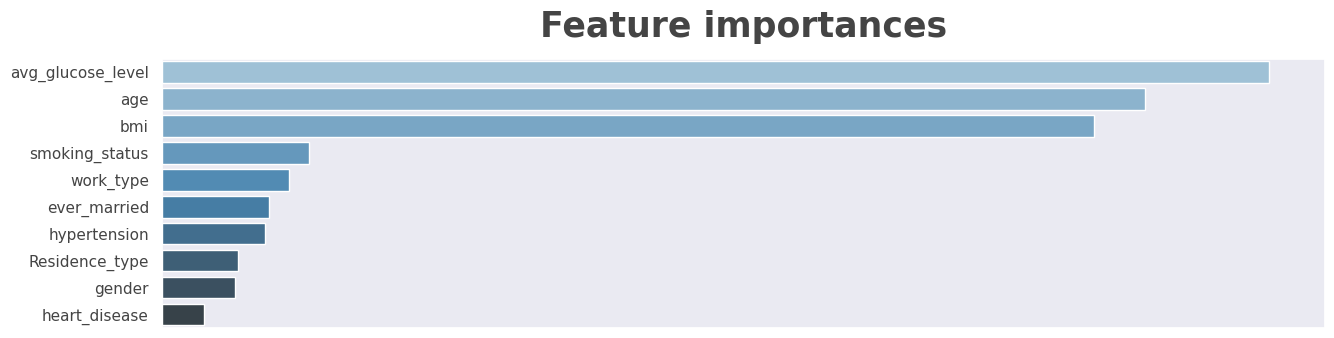

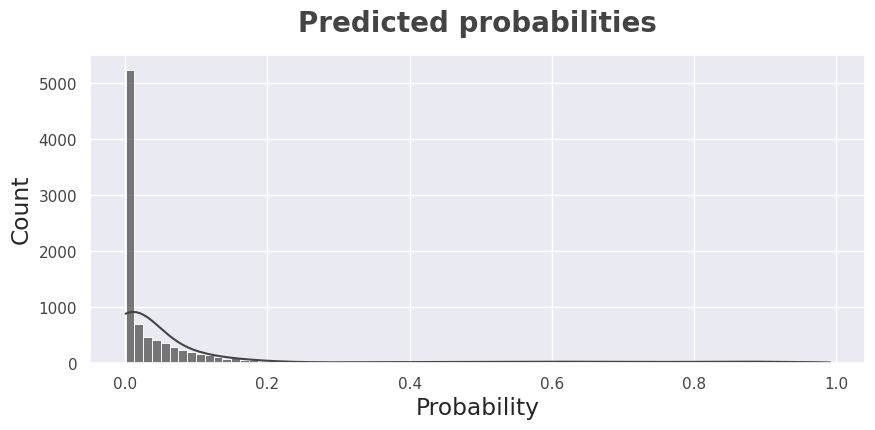

In [74]:
cat_cols = df.columns[(df.nunique() < 82) & (df.nunique() > 2)].tolist()
feat_imp = pd.DataFrame({"feature": X.columns})
predictions, scores = np.zeros(len(test)), []

FOLDS = 5
start = time.time()

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f"\n--- FOLD {fold+1} ---")

    lgb_train = lgb.Dataset(
        data=X.iloc[train_idx], label=y.iloc[train_idx], categorical_feature=cat_cols
    )
    lgb_valid = lgb.Dataset(
        data=X.iloc[val_idx],
        label=y.iloc[val_idx],
        categorical_feature=cat_cols,
        reference=lgb_train,
    )

    model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=10_000,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=["train", "val"],
        verbose_eval=False,
        callbacks=[lgb.log_evaluation(1000), lgb.early_stopping(1000, verbose=False)],
    )

    feat_imp[f"fold_{str(fold + 1)}"] = model.feature_importance()
    best_it = model.best_iteration

    val_preds = model.predict(X.iloc[val_idx], num_iteration=best_it)
    val_score = roc_auc_score(y.iloc[val_idx], val_preds)
    scores.append(val_score)

    predictions += model.predict(test, num_iteration=best_it) / FOLDS
    print(
        f"--- ROC AUC: {bold[0]}{round(val_score, 6)}{bold[1]} "
        f"| best iteration: {bold[0]}{best_it}{bold[1]} ---"
    )

    del lgb_train, lgb_valid, val_preds, val_score, model
    gc.collect()

print("*" * 45)
print(f"Mean ROC AUC: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}")
print(f"Training time (mins): {np.round((time.time() - start) / 60, 2)}\n")

feat_imp["avg_imp"] = feat_imp[feat_imp.columns[1:]].mean(axis=1)
feat_imp.sort_values("avg_imp", ascending=False, inplace=True)
feat_importance_plot(feat_imp)
plot_probabilities(predictions)

lgb_preds = predictions.copy()

### ***XGB***

In [75]:
def xgb_data(df):
    dfc = df.copy()
    for col in dfc[obj_cols].columns:
        d = pd.get_dummies(dfc[col], drop_first=dfc[col].nunique() == 2, prefix=col)
        dfc = pd.concat([dfc.drop(col, axis=1), d], axis=1)
    return dfc

I applied the same logic to the XGB parameters as I did with the LGBM parameters. I also used the same cross validation parameters.

In [76]:
xgb_params = {
    "max_depth": 3,
    "eta": 0.01,
    "lambda": 25,
    # "alpha": 1,
    "gamma": 0.3,
    # "scale_pos_weight": 10,
    # "min_child_weight": 0.5,
    "subsample": 0.55,
    "colsample_bytree": 0.55,
    "tree_method": "gpu_hist",
    "booster": "gbtree",
    "predictor": "gpu_predictor",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "seed": seed,
}


--- FOLD 1 ---
[0]	train-auc:0.66382	eval-auc:0.68524
[1000]	train-auc:0.95288	eval-auc:0.96048
[2000]	train-auc:0.95831	eval-auc:0.96186
[3000]	train-auc:0.96222	eval-auc:0.96257
[4000]	train-auc:0.96540	eval-auc:0.96264
[4403]	train-auc:0.96646	eval-auc:0.96255
--- ROC AUC: 0.96279 | best iteration: 3405 ---

--- FOLD 2 ---
[0]	train-auc:0.67014	eval-auc:0.67379
[1000]	train-auc:0.95539	eval-auc:0.94770
[2000]	train-auc:0.96029	eval-auc:0.94926
[3000]	train-auc:0.96376	eval-auc:0.94991
[4000]	train-auc:0.96666	eval-auc:0.95031
[5000]	train-auc:0.96908	eval-auc:0.95046
[5920]	train-auc:0.97091	eval-auc:0.95028
--- ROC AUC: 0.950544 | best iteration: 4921 ---

--- FOLD 3 ---
[0]	train-auc:0.67834	eval-auc:0.64118
[1000]	train-auc:0.95462	eval-auc:0.94942
[2000]	train-auc:0.95951	eval-auc:0.95222
[3000]	train-auc:0.96329	eval-auc:0.95330
[4000]	train-auc:0.96624	eval-auc:0.95347
[5000]	train-auc:0.96881	eval-auc:0.95362
[5396]	train-auc:0.96978	eval-auc:0.95365
--- ROC AUC: 0.953759 | 

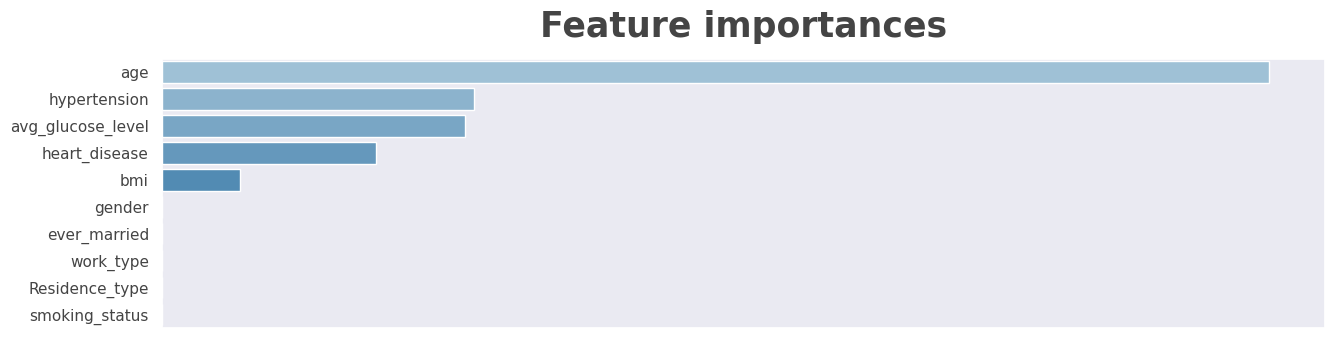

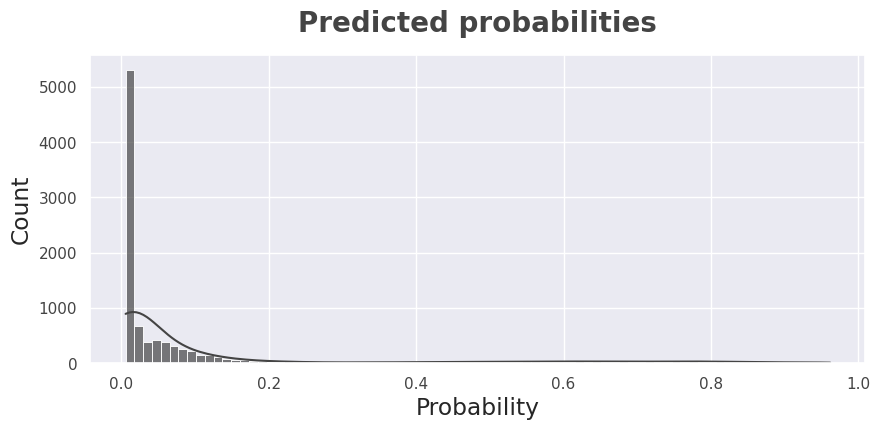

In [77]:
X_xgb = xgb_data(X)
start = time.time()
FOLDS = 5

feat_imp = pd.DataFrame({"feature": X.columns})
predictions, score = np.zeros(len(test)), []

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
for fold, (train_idx, val_idx) in enumerate(cv.split(X_xgb, y), 1):
    print(f"\n--- FOLD {fold} ---")

    dtrain = xgb.DMatrix(X_xgb.iloc[train_idx], label=y.iloc[train_idx])
    dvalid = xgb.DMatrix(X_xgb.iloc[val_idx], label=y.iloc[val_idx])
    watchlist = [(dtrain, "train"), (dvalid, "eval")]

    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=10_000,
        evals=watchlist,
        verbose_eval=1000,
        callbacks=[
            xgb.callback.EarlyStopping(
                rounds=1000, data_name="eval", maximize=True, save_best=True
            )
        ],
    )

    val_preds = model.predict(dvalid)
    val_score = roc_auc_score(y.iloc[val_idx], val_preds)
    score.append(val_score)

    predictions += model.predict(xgb.DMatrix(xgb_data(test))) / FOLDS

    print(
        f"--- ROC AUC: {bold[0]}{round(val_score, 6)}{bold[1]} "
        f"| best iteration: {bold[0]}{model.best_ntree_limit}{bold[1]} ---"
    )

    fi = model.get_score(importance_type="gain")
    fi = pd.DataFrame({"feature": fi.keys(), f"importance_{fold}": fi.values()})
    feat_imp = feat_imp.merge(fi, on="feature", how="left").fillna(0)

    del dtrain, dvalid, watchlist, val_preds, val_score, model
    gc.collect()

print("*" * 45)
print(f"Mean ROC AUC: {round(np.mean(score), 6)}")
print(f"Training time (mins): {np.round((time.time() - start) / 60, 2)}\n")

feat_imp["avg_imp"] = feat_imp[feat_imp.columns[1:]].mean(axis=1)
feat_imp.sort_values("avg_imp", ascending=False, inplace=True)
feat_importance_plot(feat_imp)
plot_probabilities(predictions)

xgb_preds = predictions.copy()

# ***Submission***

I blended the predictions with a 50/50 split

In [37]:
final_preds = xgb_preds * 0.5 + lgb_preds * 0.5

ss["stroke"] = final_preds
ss.to_csv("sub.csv", index=False)

In [38]:
!kaggle competitions submit -c playground-series-s3e2 -f sub.csv -m "IX"

100%|█████████████████████████████████████████| 264k/264k [00:00<00:00, 573kB/s]
Successfully submitted to Playground Series - Season 3, Episode 2

Thanks for reading! I hope you enjoyed this notebook. 